In [1]:
import mysql.connector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
mydb = mysql.connector.connect(host='localhost',
                               user='mimicuser',
                               passwd='mimic',
                               database='mimiciiiv13',
                              auth_plugin='mysql_native_password')

First approach to query mysql from python

In [46]:
cursor = mydb.cursor()
cursor.execute('SELECT * FROM LABEVENTS LIMIT 5')
result = cursor.fetchall()
print(result)

[(1, 2, 163353, 51143, datetime.datetime(2138, 7, 17, 20, 48), 0, 0.0, '%', None), (2, 2, 163353, 51144, datetime.datetime(2138, 7, 17, 20, 48), 0, 0.0, '%', None), (3, 2, 163353, 51146, datetime.datetime(2138, 7, 17, 20, 48), 0, 0.0, '%', None), (4, 2, 163353, 51200, datetime.datetime(2138, 7, 17, 20, 48), 0, 0.0, '%', None), (5, 2, 163353, 51221, datetime.datetime(2138, 7, 17, 20, 48), 0, 0.0, '%', 'abnormal')]


Preferred way is to load query result into a DataFrame

In [13]:
df = pd.read_sql_query("SELECT * FROM LABEVENTS LIMIT 5;", mydb)

In [14]:
df

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,1,2,163353,51143,2138-07-17 20:48:00,0,0.0,%,None
1,2,2,163353,51144,2138-07-17 20:48:00,0,0.0,%,None
2,3,2,163353,51146,2138-07-17 20:48:00,0,0.0,%,None
3,4,2,163353,51200,2138-07-17 20:48:00,0,0.0,%,None
4,5,2,163353,51221,2138-07-17 20:48:00,0,0.0,%,abnormal


Here is how we are going to test the mutual information idea:

- create a temporary table that combines LABEVENTS(SUBJECT_ID, ITEMID, CHARTTIME), Lab2Hpo(NEGATED, MAP_TO), D_LABEVENTS(LOINC)
- define patient phenotype: having a phenotype > 3 times 
  

In [116]:
cursor.execute("DROP TEMPORARY TABLE IF EXISTS combined")
cursor.execute("CREATE TEMPORARY TABLE combined AS \
               SELECT LABEVENTS.ROW_ID, LABEVENTS.SUBJECT_ID, LABEVENTS.HADM_ID, LABEVENTS.ITEMID, LABEVENTS.CHARTTIME, \
               LabHpo.NEGATED, LabHpo.MAP_TO \
               FROM LABEVENTS JOIN LabHpo on LABEVENTS.ROW_ID = LabHpo.ROW_ID")

There are some questions we need to further explore. 

* How many times did each patient get admitted into ICU?

From the following query, we can see that about 84% patients were admitted only once, 11% were admitted twice, and the rest 5% were admitted three times or more. We could just focus on the 84%. This will make our task easier as we do not need to worry about effects from other admissions.  

In [110]:
admissions_per_patient = pd.read_sql_query("WITH adm_per_patient AS \
    (SELECT count(*) as adm_time FROM ADMISSIONS GROUP BY SUBJECT_ID) \
    SELECT adm_time, count(*) as patient_n FROM adm_per_patient GROUP BY adm_time ORDER BY patient_n DESC", mydb)
admissions_per_patient['percent'] = admissions_per_patient.patient_n / np.sum(admissions_per_patient.patient_n)
admissions_per_patient[0:10]

,adm_time,patient_n,percent
0,1,38983,0.837984
1,2,5160,0.110920
2,3,1342,0.028848
3,4,508,0.010920
4,5,246,0.005288
5,6,113,0.002429
6,7,51,0.001096
7,8,31,0.000666
8,9,26,0.000559
9,10,14,0.000301


* How many abnormal phenotypes does each patient have at each admission?

From the histogram, we can see that most patients have ~20 abnormal phenotypes. 

In [52]:
abnormPerPatientAdm = pd.read_sql_query("WITH abnormal_per_patient_adm AS \
(SELECT SUBJECT_ID, HADM_ID, count(*) AS abnormal_n \
FROM combined WHERE NEGATED = 'F' GROUP BY SUBJECT_ID, HADM_ID) \
SELECT abnormal_n, count(*) AS n FROM abnormal_per_patient_adm GROUP BY abnormal_n ORDER BY n DESC ", mydb)

In [65]:
abnormPerPatientAdm.loc[abnormPerPatientAdm.n > 500, :]

,abnormal_n,n
0,8,1465
1,7,1446
2,9,1306
3,6,1260
4,10,1031
5,5,1026
6,1,915
7,4,823
8,11,783
9,12,734


A better way is to plot this.

In [66]:
abnormalities_per_patient_adm = pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, count(*) AS abnormal_n \
FROM combined WHERE NEGATED = 'F' GROUP BY SUBJECT_ID, HADM_ID", mydb)

In [74]:
abnormalities_per_patient_adm.abnormal_n.describe()

count    73678.000000
mean       127.217731
std        207.226446
min          1.000000
25%         24.000000
50%         67.000000
75%        142.000000
max       9467.000000
Name: abnormal_n, dtype: float64

In [81]:
bins = pd.cut(abnormalities_per_patient_adm.abnormal_n, bins = [-1, 0, 25, 50, 75, 100, 125, 150, 175, 200, 3000, 10000])
hist_data = abnormalities_per_patient_adm.groupby(bins).size()

In [86]:
hist_data.values

array([    0, 19284, 10949,  9581,  7447,  5339,  3707,  2785,  2252,
       12316,    18])

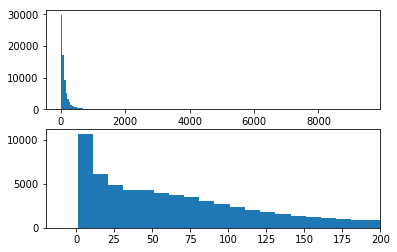

In [106]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax.hist(abnormalities_per_patient_adm.abnormal_n, 
        bins = np.arange(0, np.max(abnormalities_per_patient_adm.abnormal_n), 50))
ax = fig.add_subplot(212)
ax.hist(abnormalities_per_patient_adm.abnormal_n, 
        bins = np.arange(-9, np.max(abnormalities_per_patient_adm.abnormal_n), 10))
plt.xlim((-20, 200))
plt.show()

* How to assign that a patient has a phenotype at one admission?

We look at how many times does each abnormal phenotype occur for each patient admission.

In [118]:
pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, MAP_TO \
    FROM combined \
    WHERE NEGATED = 'F' \
    limit 5", mydb)

OperationalError: MySQL Connection not available.

In [117]:
abnormal_occurrence = pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, MAP_TO, count(*) as n \
    FROM combined \
    WHERE NEGATED = 'F' \
    GROUP BY SUBJECT_ID, HADM_ID, MAP_TO", mydb)
abnormal_occurrence

TypeError: 'NoneType' object is not iterable

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax.hist(abnormal_occrrence.n, 
        bins = np.arange(0, np.max(abnormalities_per_patient_adm.abnormal_n), 50))
ax = fig.add_subplot(212)
ax.hist(abnormalities_per_patient_adm.abnormal_n, 
        bins = np.arange(-9, np.max(abnormalities_per_patient_adm.abnormal_n), 10))
plt.xlim((-20, 200))
plt.show()

In [8]:
pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, MAP_TO, count(*) AS n FROM combined where NEGATED='F' group by SUBJECT_ID, HADM_ID, MAP_TO ", mydb)

,SUBJECT_ID,HADM_ID,MAP_TO,n
0,2,163353.0,HP:0031851,1
1,2,163353.0,HP:0020062,1
2,2,163353.0,HP:0025547,2
3,2,163353.0,HP:0025066,1
4,2,163353.0,HP:0001873,1
5,2,163353.0,HP:0031965,1
6,2,163353.0,HP:0020060,1
7,2,163353.0,HP:0001882,1
8,2,163353.0,HP:0020063,1
9,2,163353.0,HP:0100827,1


,adm_time,patient_n
0,1,38983
1,2,5160
2,3,1342
3,4,508
4,5,246
5,6,113
6,7,51
7,8,31
8,9,26
9,10,14


The above result shows that most patients were admitted once into ICU, but there are patients there were admitted more than once. 

In [119]:
cursor.close()
mydb.close()